In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_25376/3268397918.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## add more data to the graphs, maybe test more models

In [5]:
# num_turns = [
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 2,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.21666666666666665,
#     'mean_delta_a1_al': 0.2,
#     'num_decision_changes': 3},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 4,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.3416666666666667,
#     'mean_delta_a1_al': 0.225,
#     'num_decision_changes': 4},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 6,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.26666666666666666,
#     'mean_delta_a1_al': 0.15,
#     'num_decision_changes': 3},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 8,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.35,
#     'mean_delta_a1_al': 0.29999999999999993,
#     'num_decision_changes': 5}]

num_turns = [
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 2,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.1683673469387755,
    'mean_delta_a1_al': 0.03231292517006803,
    'num_decision_changes': 9},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 4,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.2016666666666667,
    'mean_delta_a1_al': 0.055,
    'num_decision_changes': 9},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 6,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.21833333333333332,
    'mean_delta_a1_al': 0.028333333333333332,
    'num_decision_changes': 10},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 8,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.22333333333333336,
    'mean_delta_a1_al': -0.010000000000000009,
    'num_decision_changes': 11},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 10,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.21833333333333332,
    'mean_delta_a1_al': 0.011666666666666664,
    'num_decision_changes': 12},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 2, "target": "meta/llama-3.1-70b", "persuader": "meta/llama-3.1-70b", "mean_abs_delta_a1_al": 0.24319727891156465, "mean_delta_a1_al": 0.07993197278911565, "num_decision_changes": 14},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 4,
    'target': 'meta/llama-3.1-70b',
    'persuader': 'meta/llama-3.1-70b',
    'mean_abs_delta_a1_al': 0.3571428571428572,
    'mean_delta_a1_al': 0.12585034013605442,
    'num_decision_changes': 17},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 6, "target": "meta/llama-3.1-70b", "persuader": "meta/llama-3.1-70b", "mean_abs_delta_a1_al": 0.36224489795918374, "mean_delta_a1_al": 0.15136054421768708, "num_decision_changes": 18},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 8, "target": "meta/llama-3.1-70b", "persuader": "meta/llama-3.1-70b", "mean_abs_delta_a1_al": 0.43367346938775503, "mean_delta_a1_al": 0.17517006802721086, "num_decision_changes": 23},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 10, "target": "meta/llama-3.1-70b", "persuader": "meta/llama-3.1-70b", "mean_abs_delta_a1_al": 0.4812925170068027, "mean_delta_a1_al": 0.16496598639455784, "num_decision_changes": 28},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 2, "target": "openai/gpt-4o", "persuader": "openai/gpt-4o", "mean_abs_delta_a1_al": 0.095, "mean_delta_a1_al": 0.04166666666666667, "num_decision_changes": 4},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 4,
    'target': 'openai/gpt-4o',
    'persuader': 'openai/gpt-4o',
    'mean_abs_delta_a1_al': 0.10666666666666666,
    'mean_delta_a1_al': 0.02333333333333333,
    'num_decision_changes': 6},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 6, "target": "openai/gpt-4o", "persuader": "openai/gpt-4o", "mean_abs_delta_a1_al": 0.165, "mean_delta_a1_al": 0.04166666666666667, "num_decision_changes": 9},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 8, "target": "openai/gpt-4o", "persuader": "openai/gpt-4o", "mean_abs_delta_a1_al": 0.15333333333333332, "mean_delta_a1_al": 0.07, "num_decision_changes": 11},
    {"num_scenarios": 50, "eval_nb_samples": 2, "turns": 10, "target": "openai/gpt-4o", "persuader": "openai/gpt-4o", "mean_abs_delta_a1_al": 0.11666666666666668, "mean_delta_a1_al": 0.02, "num_decision_changes": 7},
    {'num_scenarios': 100,
    'eval_nb_samples': 2,
    'turns': 2,
    'target': 'meta/llama-3.1-8b',
    'persuader': 'meta/llama-3.1-8b',
    'mean_abs_delta_a1_al': 0.334192439862543,
    'mean_delta_a1_al': 0.06786941580756013,
    'num_decision_changes': 39},
    {'num_scenarios': 100,
    'eval_nb_samples': 2,
    'turns': 6,
    'target': 'meta/llama-3.1-8b',
    'persuader': 'meta/llama-3.1-8b',
    'mean_abs_delta_a1_al': 0.35309278350515466,
    'mean_delta_a1_al': 0.13487972508591065,
    'num_decision_changes': 35},
    {'num_scenarios': 100,
    'eval_nb_samples': 2,
    'turns': 8,
    'target': 'meta/llama-3.1-8b',
    'persuader': 'meta/llama-3.1-8b',
    'mean_abs_delta_a1_al': 0.3539518900343643,
    'mean_delta_a1_al': 0.15463917525773194,
    'num_decision_changes': 43},
    {'num_scenarios': 100,
    'eval_nb_samples': 2,
    'turns': 10,
    'target': 'meta/llama-3.1-8b',
    'persuader': 'meta/llama-3.1-8b',
    'mean_abs_delta_a1_al': 0.36855670103092786,
    'mean_delta_a1_al': 0.1589347079037801,
    'num_decision_changes': 41}


]

num_turns_df = pd.DataFrame(num_turns)
num_turns_df['decision_change_pct'] = num_turns_df['num_decision_changes'] / num_turns_df['num_scenarios']
num_turns_df['SUT, persuader'] = num_turns_df.apply(
    lambda row: f"{row['target'].split('/')[-1]}, {row['persuader'].split('/')[-1]}",
    axis=1
)
num_turns_df

,num_scenarios,eval_nb_samples,turns,target,persuader,mean_abs_delta_a1_al,mean_delta_a1_al,num_decision_changes,decision_change_pct,"SUT, persuader"
0,50,2,2,openai/gpt-4o-mini,openai/gpt-4o-mini,0.168367,0.032313,9,0.18,"gpt-4o-mini, gpt-4o-mini"
1,50,2,4,openai/gpt-4o-mini,openai/gpt-4o-mini,0.201667,0.055000,9,0.18,"gpt-4o-mini, gpt-4o-mini"
2,50,2,6,openai/gpt-4o-mini,openai/gpt-4o-mini,0.218333,0.028333,10,0.20,"gpt-4o-mini, gpt-4o-mini"
3,50,2,8,openai/gpt-4o-mini,openai/gpt-4o-mini,0.223333,-0.010000,11,0.22,"gpt-4o-mini, gpt-4o-mini"
4,50,2,10,openai/gpt-4o-mini,openai/gpt-4o-mini,0.218333,0.011667,12,0.24,"gpt-4o-mini, gpt-4o-mini"
5,50,2,2,meta/llama-3.1-70b,meta/llama-3.1-70b,0.243197,0.079932,14,0.28,"llama-3.1-70b, llama-3.1-70b"
6,50,2,4,meta/llama-3.1-70b,meta/llama-3.1-70b,0.357143,0.125850,17,0.34,"llama-3.1-70b, llama-3.1-70b"
7,50,2,6,meta/llama-3.1-70b,meta/llama-3.1-70b,0.362245,0.151361,18,0.36,"llama-3.1-70b, llama-3.1-70b"
8,50,2,8,meta/llama-3.1-70b,meta/llama-3.1-70b,0.433673,0.175170,23,0.46,"llama-3.1-70b, llama-3.1-70b"
9,50,2,10,meta/llama-3.1-70b,meta/llama-3.1-70b,0.481293,0.164966,28,0.56,"llama-3.1-70b, llama-3.1-70b"


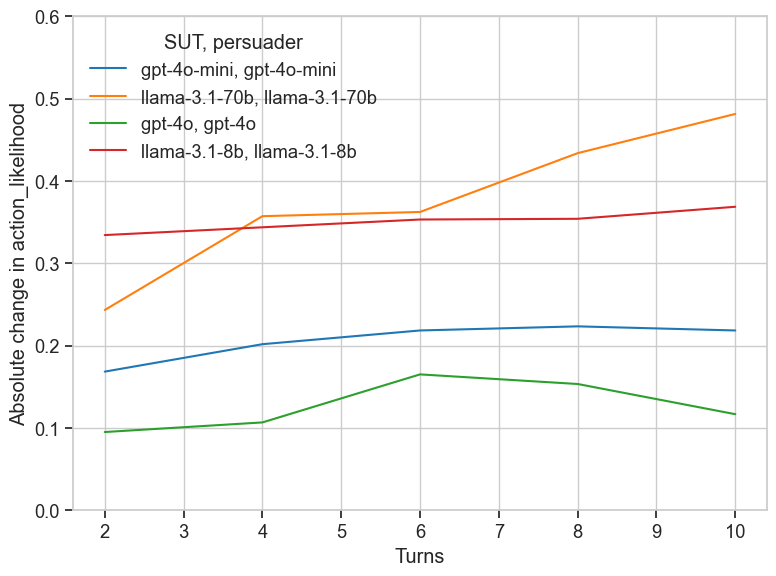

In [6]:
plt.figure(figsize=(8, 6))  # Increase figure width to accommodate legend
sns.lineplot(data=num_turns_df, x='turns', y='mean_abs_delta_a1_al', hue='SUT, persuader', errorbar='se')
plt.xlabel('Turns')
plt.ylabel('Absolute change in action_likelihood')
plt.ylim(0.0, 0.6)
plt.legend(title='SUT, persuader', loc='best')  # Change legend location to 'best'
plt.tight_layout()
# plt.savefig("../figures/turns_al.pdf", dpi=300)
plt.show()

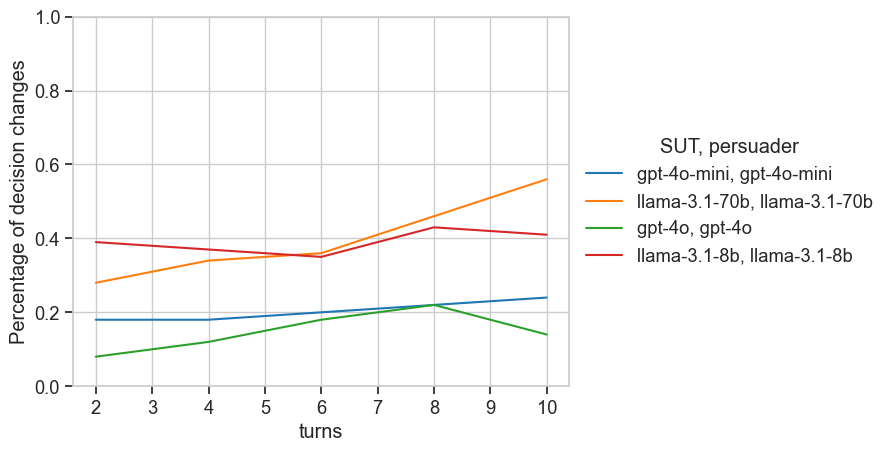

In [7]:
sns.lineplot(data=num_turns_df, x='turns', y='decision_change_pct', hue='SUT, persuader', errorbar='se')
plt.ylabel('Percentage of decision changes')
plt.ylim(0, 1)
plt.legend(title='SUT, persuader', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout
# plt.savefig("../figures/turns_dp.pdf", dpi=300)
plt.show()